In [1]:

import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import librosa
from datagenerator2 import DataGenerator2


2770 samples in dataset
total_samples: 2770
total_points: 277000


In [2]:
pkl_list = ['D:/soundseperation/TIMIT_WAV/Data/train' + str(i) + '.pkl' for i in range(1, 2)]

In [4]:
data_generator = DataGenerator2(pkl_list)
print("Training set: Data samples: %d, Total number of points: %d"%(data_generator.total_samples, data_generator.total_number_of_datapoints()))

# remove variables
del pkl_list

2770 samples in dataset
Training set: Data samples: 2770, Total number of points: 277000


In [5]:
#%% Get data

# Get batch size
batch_size = 64;

# Get total number of batches
total_batches = int(data_generator.total_batches(batch_size))

# Get sample data
data = data_generator.gen_batch(batch_size);
# Reshape training data
# concatenate training samples together to get 101900 x 129 array
tr_features = np.concatenate([item['SampleStd'] for item in data], axis=0)
# concatenate labels together to get 101900 x 129 array
Y_labels = (np.concatenate([np.asarray(item['IBM'])[:,:,0] for item in data], axis=0)).astype(int)

# Same as neff
n_features = np.shape(tr_features)[1]
# Same as neff
n_classes = np.shape(Y_labels)[1]

print("total_batches size: %d"%total_batches)
print("n_features size: %d"%n_features)
print("n_classes size: %d"%n_classes)
print(tr_features.shape)
print(str(Y_labels.shape))

total_batches size: 43
n_features size: 129
n_classes size: 129
(6400, 129)
(6400, 129)


In [6]:
del data, tr_features, Y_labels

In [7]:
#%% Reset default graph

# tf.reset_default_graph()
tf.compat.v1.reset_default_graph()

#%% Set training parameters

training_epochs = 60
n_neurons_in_h1 = 300
n_neurons_in_h2 = 300
learning_rate = 0.01

#%% Placeholders for inputs and outputs
# tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(tf.float32, [None, n_features], name="features")
Y = tf.compat.v1.placeholder(tf.float32, [None, n_classes], name="labels")

#%% Layer 1

W1 = tf.Variable(tf.compat.v1.truncated_normal([n_features, n_neurons_in_h1], mean=0, stddev=1/np.sqrt(n_features)), name="weights1")
b1 = tf.Variable(tf.compat.v1.truncated_normal([n_neurons_in_h1], mean=0, stddev=1/np.sqrt(n_features)), name="biases1")
# Activation function
y1 = tf.nn.tanh((tf.matmul(X, W1)+b1), name="activationlayer1")

#%% Layer 2

W2 = tf.Variable(tf.compat.v1.random_normal([n_neurons_in_h1, n_neurons_in_h2], mean=0, stddev=1/np.sqrt(n_features)), name="weights2")
b2 = tf.Variable(tf.compat.v1.random_normal([n_neurons_in_h2],mean=0, stddev=1/np.sqrt(n_features)), name="biases2")
#Activation function
y2 = tf.nn.tanh((tf.matmul(y1,W2)+b2), name="activationlayer2")

#%% ouput layer

W0 = tf.Variable(tf.compat.v1.random_normal([n_neurons_in_h2, n_classes], mean=0, stddev=1/np.sqrt(n_features)), name="weightsOut")
b0 = tf.Variable(tf.compat.v1.random_normal([n_classes], mean=0, stddev=1/np.sqrt(n_features)), name="biasesOut")
#Activation function (tanh)
a = tf.nn.sigmoid((tf.matmul(y2, W0)+b0), name="activationOutputLayer")

In [8]:
#MSE
loss = tf.losses.mean_squared_error(Y, a)

#Optimizer
train_step = tf.compat.v1.train.GradientDescentOptimizer(learning_rate).minimize(loss)

#%% Accuracy calculation

#Get prediction from output
correct_prediction = tf.equal(tf.round(a), Y)
#Accuracy determination
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="Accuracy")

In [9]:
#%% Run model

#folder for writer location
#Make sure there is a folder called WriterOutput held in the current directory
foldername = "WriterOutput"

#Location for model checkpoint
#Save to current directory
model_checkpoint = "./model.chkpt"

# Create a saver so we can save and load the model as we train it
tf_saver = tf.compat.v1.train.Saver()


initial = tf.compat.v1.global_variables_initializer()

#create session
with tf.compat.v1.Session() as sess:
    sess.run(initial)
    writer = tf.compat.v1.summary.FileWriter(foldername)
    writer.add_graph(sess.graph)
    merged_summary = tf.compat.v1.summary.merge_all()
    accuracy_results = []
    loss_results = []
    
    # Start timer
    start = time.time()
    
    for epoch in range(training_epochs):
        # create array to hold intermediate results for accuracy and loss
        intermediate_accuracy = []
        intermediate_loss = []
         
        # loop through each batch in the dataset
        for i in range(0, total_batches):
            
            # Get data
            data = data_generator.gen_batch(batch_size);
            # Reshape training data
            # concatenate training samples together to get 101900 x 129 array
            tr_features = np.concatenate([item['SampleStd'] for item in data], axis=0)
            # concatenate labels together to get 101900 x 129 array
            Y_labels = (np.concatenate([np.asarray(item['IBM'])[:,:,0] for item in data], axis=0)).astype(int)
            
            _, loss1, accuracy1 = sess.run([train_step, loss, accuracy], feed_dict={X: tr_features, Y:Y_labels})
            #Add loss and accuracy to intermediate array
            intermediate_loss.append(loss1)
            intermediate_accuracy.append(accuracy1)
            
        # Append mean of loss and accuracy over batch to accuracy_loss results
        accuracy_results.append(np.mean(intermediate_accuracy))
        loss_results.append(np.mean(intermediate_loss))

        #writer.add_summary(summary, epoch)
        print("epoch", epoch)
    save_path = tf_saver.save(sess, model_checkpoint)
    
    # finish timer 
    end = time.time()
    
print("Model trained. Time elapsed: %f"%(end - start))

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
Model trained. Time elapsed: 170.724614


In [19]:
print(a.OVERLOADABLE_OPERATORS)

{'__rpow__', '__gt__', '__div__', '__rmatmul__', '__rand__', '__truediv__', '__eq__', '__rxor__', '__ne__', '__rmul__', '__le__', '__neg__', '__and__', '__invert__', '__rtruediv__', '__add__', '__getitem__', '__pow__', '__mul__', '__rdiv__', '__sub__', '__xor__', '__ror__', '__or__', '__rfloordiv__', '__radd__', '__abs__', '__mod__', '__rsub__', '__lt__', '__rmod__', '__ge__', '__matmul__', '__floordiv__'}


In [20]:
model_checkpoint = "./model.chkpt"
print(model_checkpoint)

./model.chkpt


In [ ]:
del i, loss1, accuracy1, intermediate_accuracy, intermediate_loss, epoch
del foldername, model_checkpoint
del save_path, learning_rate, n_classes, n_features, n_neurons_in_h1, n_neurons_in_h2
del Y_labels, data, tr_features
del total_batches, merged_summary, batch_size
del start, end

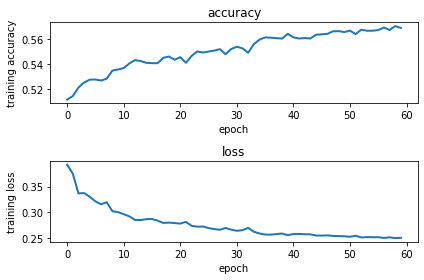

In [21]:
#%% Plot training accuracy and loss

fig = plt.figure() 

#sub plot 1 - Accuracy
ax1 = plt.subplot(211)
plt.plot(range(training_epochs), accuracy_results, linewidth=2.0)
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.title('accuracy')

#sub plot 2 - Loss
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(range(training_epochs), loss_results, linewidth=2.0)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('loss')

plt.tight_layout()
fig.savefig("feedforwardaccuracy.png", bbox_inches="tight")
plt.show()
plt.close(fig)

In [38]:
wavfile1 = "D:/soundseperation/TIMIT_WAV/Train/DR1/FCJF0/SI1027.WAV" 
wavfile2 = "D:/soundseperation/TIMIT_WAV/Train/DR1/MDPK0/SI552.WAV" 

sampling_rate = 8000
frame_size = 256
maxFFTSize = 129

vad_threshold= 0.001


In [55]:
 #Function to return wav files
def GetSeperateSignals( wavfile1, wavfile2, sampling_rate):
    #load first speaker
    speech_1, _ = librosa.core.load(wavfile1, sr=sampling_rate)
    #load second speaker
    speech_2, _ = librosa.core.load(wavfile2, sr=sampling_rate)
    
    # mix 2 speech signals together
    # Reduce length of signals so that they are a multiple of 128
    length = min(len(speech_1), len(speech_2))
    #length = int(math.floor(length / 128.0)) * 128
    speech_1 = speech_1[:length]
    speech_2 = speech_2[:length]
    speech_mix = speech_1 + speech_2
    
    return speech_1, speech_2, speech_mix, (length / sampling_rate)

In [49]:
from scipy import signal
def stft(wavfile, sampling_rate, frame_size, overlapFac=0.75):
        """ short time fourier transform of audio signal """
        
        #Set window size
        overlap = int(overlapFac*frame_size)
        #Get stft
        f1, t1, Zsamples1 = signal.stft(wavfile, fs=sampling_rate, window='hann', nperseg = frame_size, return_onesided=True, noverlap=overlap, axis=1)
    
        return Zsamples1, f1, t1

In [50]:
def istft(spectrogram, sampling_rate, frame_size, overlapFac=0.75):
        """ short time fourier transform of audio signal """
        
        #Set window size
        overlap = int(overlapFac*frame_size)
        #Get istft
        t1, samplesrec = signal.istft(spectrogram, fs=sampling_rate, window='hann', nperseg = frame_size, input_onesided = True, noverlap=overlap, time_axis=-2, freq_axis=-1)

        return samplesrec

In [42]:
mean = -3.7185277644387273
std = 0.7873899776985277

In [56]:
def CreateTrainingDataSpectrogram(wavfile1, wavfile2, sampling_rate, frame_size, maxFFTSize, vad_threshold):
        
        #Get separate and mixed speech signals
        speech_1, speech_2, speech_mix, signal_length = GetSeperateSignals( wavfile1, wavfile2,sampling_rate= sampling_rate)
        
        # compute stft spectrum for 1st speaker
        speech_1_spec, _, _ = stft(speech_1, sampling_rate, frame_size)
        speech_1_mag = np.abs(speech_1_spec[:, :maxFFTSize])
        speech_1_phase_raw = np.angle(speech_1_spec[:, :maxFFTSize])
        speech_1_phase_std = speech_1_phase_raw / np.pi
        
        # compute stft spectrum for 2nd speaker
        speech_2_spec, _, _ = stft(speech_2, sampling_rate, frame_size)
        speech_2_mag = np.abs(speech_2_spec[:, :maxFFTSize])
        speech_2_phase_raw = np.angle(speech_2_spec[:, :maxFFTSize])
        speech_2_phase_std = speech_2_phase_raw / np.pi
        
        # compute log stft spectrum for mixture of both speaker
        speech_mix_spec0, f1, t1 = stft(speech_mix, sampling_rate, frame_size)
        speech_mix_mag = np.abs(speech_mix_spec0[:, :maxFFTSize])
        speech_mix_phase_raw = np.angle(speech_mix_spec0[:, :maxFFTSize])
        # Get additional frequency spectrum for mixture signal
        speech_mix_mag_log = np.log10(speech_mix_mag)
        # Standardise spectrogram by minus mean and divide by standard deviation
        # Global mean and standard deviation are worked out in Get-mean-and-std.py script
        speech_mix_mag_std = (speech_mix_mag_log - mean) / std
        speech_mix_phase_std = speech_mix_phase_raw / np.pi
        #Convert speech_mix_spec to float16 to save on memory
        speech_mix_mag_log = speech_mix_mag_log.astype('float16')
        speech_mix_mag_std = speech_mix_mag_std.astype('float16')
               
        # VAD is voice activity detection. If magnitude is greater than threshold then a voice is active.
        speech_VAD = (speech_mix_mag.sum(axis=1) > 0.005).astype(int)
        #Convert VAD to boolean
        speech_VAD = speech_VAD.astype(bool)
        
        # Create Ideal Binary Mask
        # 2 IBMs are created. One for the first signal and one for the second signal
        IBM = np.array([speech_1_mag > speech_2_mag, speech_1_mag < speech_2_mag]).astype(bool)
        #Transpose IBM around so that it is 2 columns of n frequency points for each time point
        IBM = np.transpose(IBM, [1, 2, 0])
        
        # Create Ideal Ratio Mask
        # 2 IRMs are created. One for the first signal and one for the second signal
        SNR1 = np.log10(np.divide(speech_1_mag, speech_2_mag))
        SNR2 = np.log10(np.divide(speech_2_mag, speech_1_mag))
        IRM = np.array([(np.power(10, SNR1) / (np.power(10, SNR1) + 1)), (np.power(10, SNR2) / (np.power(10, SNR2) + 1))]).astype('float16')
        #Transpose IBM around so that it is 2 columns of n frequency points for each time point
        IRM = np.transpose(IRM, [1, 2, 0])
        
        #sample_dict = {'SampleStd': speech_mix_mag_std, 'SampleLog': speech_mix_mag_log, 'VAD': speech_VAD, 'IBM': IBM1, 'IRM': IRM1,'Wavfiles': [wavfile1, wavfile2], 'MixtureSignal': speech_mix, 'ZmixedSeries': speech_mix_spec0, 'fmixed': f1, 'tmixed': t1, 'Signal1': speech_1, 'Signal2': speech_2, 'Spectrogram1': speech_1_mag, 'Spectrogram2':speech_2_mag }
        sample_dict = {'SampleStd': speech_mix_mag_std, 'SampleLog': speech_mix_mag_log, 'SamplePhaseRaw': speech_mix_phase_raw, \
                       'SamplePhaseStd':speech_mix_phase_std, 'SampleMagRaw': speech_mix_mag, 'VAD': speech_VAD, 'IBM': IBM, 'IRM': IRM, \
                       'Wavfiles': [wavfile1, wavfile2], 'MixtureSignal': speech_mix, 'ZmixedSeries': speech_mix_spec0, \
                       'fmixed': f1, 'tmixed': t1, 'Signal1': speech_1, 'Signal2': speech_2, 'Speech1Magnitude': speech_1_mag, \
                       'Speech2Magnitude': speech_2_mag, 'Speech1PhaseRaw': speech_1_phase_raw, 'Speech2PhaseRaw': speech_2_phase_raw, \
                       'Speech1PhaseStd': speech_1_phase_std, 'Speech2PhaseStd': speech_2_phase_std, \
                       'SignalLength': signal_length}


        return sample_dict

In [57]:
# from datagenerator_scipy import DataGenerator
#Get spectrogram of two wav files combined
testdata = CreateTrainingDataSpectrogram(wavfile1= wavfile1, wavfile2= wavfile2, sampling_rate = sampling_rate,frame_size= frame_size,maxFFTSize= maxFFTSize,vad_threshold= vad_threshold)

In [58]:
ts_features = testdata['SampleStd'][testdata['VAD']]

In [59]:
model_checkpoint = "./model.chkpt"

In [63]:
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
        
    #restore session from checkpoint
    saver.restore(sess, model_checkpoint)
    
    # get inferred ibm using trained model
    ibm_batch = sess.run([a], feed_dict={X: ts_features})

INFO:tensorflow:Restoring parameters from ./model.chkpt


In [64]:
ibm_array = np.concatenate([item for item in ibm_batch], axis=0)

In [65]:
ibm_array

array([[0.37852418, 0.2675526 , 0.09095582, ..., 0.4640725 , 0.46506384,
        0.48057547],
       [0.41402844, 0.28575426, 0.09716812, ..., 0.40419737, 0.42095265,
        0.41951287],
       [0.46121138, 0.32791767, 0.10984126, ..., 0.3518383 , 0.3711797 ,
        0.37377173],
       ...,
       [0.39472586, 0.3543957 , 0.19226518, ..., 0.52177763, 0.49971104,
        0.54118085],
       [0.37747648, 0.35017866, 0.24553397, ..., 0.5505    , 0.5220851 ,
        0.5400195 ],
       [0.41617846, 0.341236  , 0.15897474, ..., 0.59261554, 0.5647098 ,
        0.55891997]], dtype=float32)

In [66]:
#Round each point to 0 or 1
ibm_array = (np.round(ibm_array, 0)).astype(int)

#Add extra points to IBM where VAD is 0
vad = np.where(testdata['VAD'] == False)[0]
vad1 = np.subtract(vad, np.asarray(range(vad.shape[0])))
ibm = np.insert(ibm_array, vad1, 0, axis=0)

In [84]:
ibm_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [85]:
ibm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

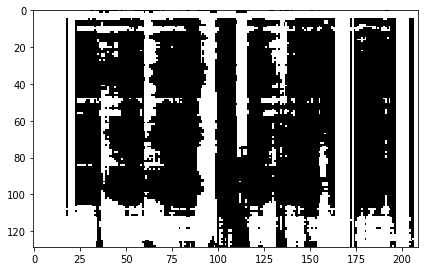

In [67]:
#%% Show mask

fig = plt.figure() 
plt.imshow(ibm.transpose(), cmap='Greys', interpolation='none')

plt.tight_layout()
fig.savefig("feedforwardibm2.png", bbox_inches="tight")
plt.show()
plt.close(fig)

In [86]:
#%% apply ibm to signal and convert back into time domain

# Convert spectrogram from log to normal
split_spectrogram = np.power(10, (ts_features * std) + mean)

In [73]:
# Add extra points to IBM whre VAD is 0
vad = np.where(testdata['VAD'] == False)[0]
vad1 = np.subtract(vad, np.asarray(range(vad.shape[0])))
split_spectrogram = np.insert(split_spectrogram, vad1, 0, axis=0)

In [74]:
# Apply ibm to spectrogram
split_spectrogram1 = np.multiply(split_spectrogram, ibm)

In [76]:
# Get recovered mixture from istft routine
wav_recovered =istft(split_spectrogram1, sampling_rate, frame_size)

In [80]:
def stft_from_mag_and_phase( radii, angle_radians):
        return radii * np.exp(1j*angle_radians)  

In [81]:
# Get phase from testing routine
phase = testdata['SamplePhaseRaw']
   
# Get recovered mixture from istft routine with phase 
phase = np.multiply(phase, ibm)
split_spectrogram2 = stft_from_mag_and_phase(split_spectrogram1, phase)
wav_recovered_with_phase = istft(split_spectrogram2, sampling_rate, frame_size)  

del split_spectrogram, split_spectrogram1, vad, vad1, phase

In [83]:
import soundfile as sf
sf.write('separated_signal.wav', wav_recovered, sampling_rate)

print("file saved")


file saved
